In [26]:
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen
import cv2
from imutils import paths

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
dir_path = r"C:\dl_proje\fire detection\dataset"

In [3]:
target_size=(224,224)
waste_label={'no':0,'yes':1}

In [4]:
def load_datasets(path):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    print(f"Toplam görüntü sayısı: {len(image_paths)}")
    print("İlk 5 görüntü yolu:")
    print(image_paths[:5])
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Görüntü okunamadı: {image_path}")
            continue
        img = cv2.resize(img, target_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_label[label])
    x, labels = shuffle(x, labels, random_state=42)
    print(f'x in boyutu {np.array(x).shape}')
    print(f'label sınıf sayısı {len(np.unique(labels))}, gözlem sayısı {len(labels)}')
    return np.array(x), np.array(labels)


In [5]:
x,labels=load_datasets(dir_path)

Toplam görüntü sayısı: 1326
İlk 5 görüntü yolu:
['C:\\dl_proje\\fire detection\\dataset\\no\\0.48007200_1530881924_final_forest.jpg', 'C:\\dl_proje\\fire detection\\dataset\\no\\0.64133000_1519374442_forest_deep.jpg', 'C:\\dl_proje\\fire detection\\dataset\\no\\0.72918000_1559733279_forests1_gettyimages_.jpg', 'C:\\dl_proje\\fire detection\\dataset\\no\\0.98884800_1554454572_spin.jpg', 'C:\\dl_proje\\fire detection\\dataset\\no\\01_NeilBurnell_Mystical_photoverticall.jpg']
Görüntü okunamadı: C:\dl_proje\fire detection\dataset\no\non_fire.189.png
x in boyutu (1325, 224, 224, 3)
label sınıf sayısı 2, gözlem sayısı 1325


In [6]:
def goruntule(image_1,label_1):
    plt.figure(figsize=(8,8))
    for i in range(10):
        ax=plt.subplot(2,5,i+1)
        plt.imshow(image_1[i])
        plt.title(np.array(list(waste_label.keys()))[to_categorical(label_1,num_classes=2)[i]==1][0].title())
        plt.axis('off')

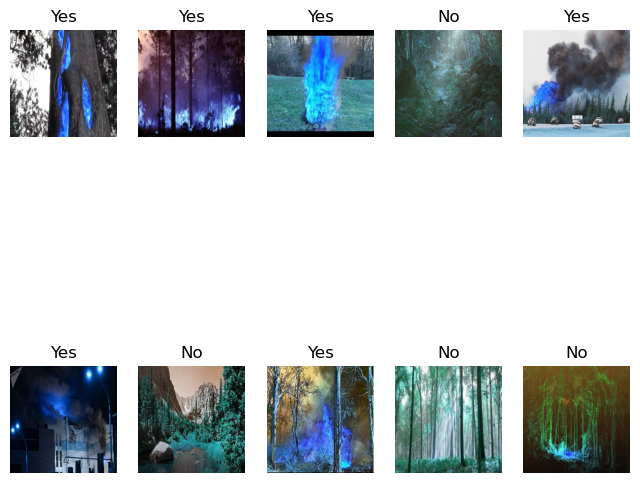

In [7]:
goruntule(x,labels)

In [8]:
#IMAGEDATAGENERATOR FONKSİYONUN GÖREVİ VERİ ÜRETMEKTİR,KÜÇÜK BİR GÖRÜNTÜ KÜMESİNDEN ÇEŞİTLİ VERİ ÜRETİR
#GÖRÜNTÜLERE GÖRÜNTÜ ÇEŞİTLENDİRME TEKNİKLERİ UYGULAYARAK GERÇEK DÜNYADAKİ GİBİ BİR HAL VERECEĞİZ
train=ImageDataGenerator(
    horizontal_flip=True,#görüntüleri rastgele yatay olarak cevirmekte
    vertical_flip=True,#dikey olarak
    validation_split=0.1,#test veri setinin oranı
    rescale=1./255,#yeniden ölçeklendirme,resimleri 0 ile 1 arasına ölçeklendiriyor
    shear_range=0.1,#görüntünün şekline eğim veriyor
    zoom_range=0.1,#genişlik kaydırma
    height_shift_range=0.1,
    width_shift_range=0.1
    
)

test=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5
)

In [19]:
train_generator=train.flow_from_directory(
    directory=dir_path,
    target_size=(target_size),
    class_mode='binary',
    subset='training'
    
)

test_generator=test.flow_from_directory(directory=dir_path,
                                        target_size=(target_size),
                                        class_mode='binary',
                                        subset='validation',
                                        batch_size=6
                                       )

Found 1194 images belonging to 2 classes.
Found 663 images belonging to 2 classes.


In [10]:
input_shape=(224,224,3)

In [11]:
model=Sequential()

In [12]:
model.add(Conv2D(
    filters=28,
    kernel_size=(2,2),
    padding='same',
    input_shape=(input_shape),
    activation='relu'
    
    
))

model.add(MaxPooling2D(
    pool_size=2,
    strides=(2,2)
    
))

model.add(Conv2D(
    filters=56,
    kernel_size=(2,2),
    padding='same',
    input_shape=(input_shape),
    activation='relu'
    
    
))

model.add(MaxPooling2D(
    pool_size=2,
    strides=(2,2)
    
))

model.add(Conv2D(
    filters=28,
    kernel_size=(2,2),
    padding='same',
    input_shape=(input_shape),
    activation='relu'
    
    
))

model.add(MaxPooling2D(
    pool_size=2,
    strides=(2,2)
    
))

In [13]:
model.add(Flatten())

In [14]:
model.add(Dense(units=48,activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=24,activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=1,activation='sigmoid'))
model.add(Dropout(rate=0.1))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 28)        │             364 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 28)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 56)        │           6,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 28)          │           6,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │       1,053,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,067,937 (4.07 MB)

 Trainable params: 1,067,937 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'acc']
)

callbacks=[EarlyStopping(monitor='acc',patience=5,mode='max',verbose=1)]

In [17]:
history=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=20,
                  callbacks=callbacks,

                  
                 )

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.7113 - loss: 1.5185 - precision: 0.7674 - recall: 0.8380 - val_acc: 0.9487 - val_loss: 0.1358 - val_precision: 0.9727 - val_recall: 0.9511
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.8587 - loss: 1.3700 - precision: 0.9348 - recall: 0.8456 - val_acc: 0.9382 - val_loss: 0.1956 - val_precision: 0.9199 - val_recall: 0.9956
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.8552 - loss: 1.3454 - precision: 0.9167 - recall: 0.8610 - val_acc: 0.9442 - val_loss: 0.1582 - val_precision: 0.9905 - val_recall: 0.9267
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.8842 - loss: 1.2619 - precision: 0.9566 - recall: 0.8707 - val_acc: 0.9442 - val_loss: 0.1496 - val_precision: 0.9928 - val_recall: 0.9244
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.9008 - loss: 1.0566 - precision: 0.9766 - recall: 0.8749 - val_acc: 0.9683 - val_loss: 0.1148 - val_precision: 0.9931 - val_recall: 0.9600
Epoch 6/20

In [29]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Katmanları dondur

# 🔧 Yeni sınıflandırma katmanları
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ⚙️ Derle
model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

# 🛑 Erken durdurma ve model kaydı
early_stop = EarlyStopping(monitor='acc', patience=10,mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("resnet_yangin_model.h5", save_best_only=True)

# 🎯 Eğit
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5840 - loss: 0.9141

38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.5847 - loss: 0.9102 - val_accuracy: 0.6787 - val_loss: 0.6231
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.6663 - loss: 0.6443 - val_accuracy: 0.6787 - val_loss: 0.6284
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6807 - loss: 0.6208

38/38 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.6806 - loss: 0.6208 - val_accuracy: 0.6787 - val_loss: 0.6070
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.6840 - loss: 0.6247 - val_accuracy: 0.6787 - val_loss: 0.6135
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.6630 - loss: 0.6258 - val_accuracy: 0.6787 - val_loss: 0.6078
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6722 - loss: 0.6237

38/38 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.6724 - loss: 0.6236 - val_accuracy: 0.6787 - val_loss: 0.5933
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6871 - loss: 0.6132 - val_accuracy: 0.6787 - val_loss: 0.5972
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6816 - loss: 0.6122 - val_accuracy: 0.6787 - val_loss: 0.5984
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6494 - loss: 0.6311 - val_accuracy: 0.6787 - val_loss: 0.5965
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6792 - loss: 0.6290 - val_accuracy: 0.6787 - val_loss: 0.5998
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6854 - loss: 0.6220

38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6852 - loss: 0.6218 - val_accuracy: 0.6863 - val_loss: 0.5712
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6805 - loss: 0.6028 - val_accuracy: 0.6787 - val_loss: 0.6144
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6893 - loss: 0.6077 - val_accuracy: 0.6787 - val_loss: 0.6130
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6645 - loss: 0.6107 - val_accuracy: 0.6787 - val_loss: 0.5762
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6848 - loss: 0.6010 - val_accuracy: 0.6787 - val_loss: 0.5903
Epoch 16/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6905 - loss: 0.5927

38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6902 - loss: 0.5928 - val_accuracy: 0.6787 - val_loss: 0.5704
Epoch 17/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6910 - loss: 0.5765 - val_accuracy: 0.6787 - val_loss: 0.6074
Epoch 18/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6799 - loss: 0.6059

38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6799 - loss: 0.6059 - val_accuracy: 0.6787 - val_loss: 0.5489
Epoch 19/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6937 - loss: 0.5848 - val_accuracy: 0.6787 - val_loss: 0.6014
Epoch 20/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6651 - loss: 0.6173

38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6655 - loss: 0.6169 - val_accuracy: 0.6787 - val_loss: 0.5437
